In [1]:
import numpy as np
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
import collections
import itertools
from utils import *
from smoothing import *

In [12]:
N_dim = 32

p_star = generate_p_star(N=N_dim,a=1.5,symmetric=False,normalized=True)

eigs_true,evecs_true = np.linalg.eig(p_star)

pmi_star = get_pmi_matrix(p_star,ppmi=True)

eigs_true_pmi, evecs_true_pmi = np.linalg.eig(pmi_star)

(0.0, 10.0)

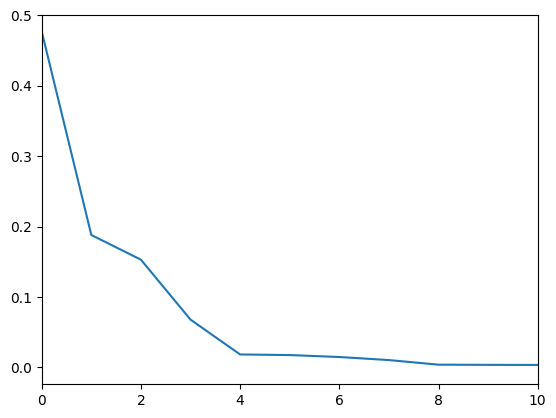

In [13]:
plt.plot(sorted(p_star.flatten())[::-1])
plt.xlim(0,10)

In [17]:
n = 10000
samples = sample_from_2d(p_star,n,return_p_hat=False)

In [59]:
num_samples = [10000,50000,100000,200000,500000]
alphas = [0.25,0.5,0.75,1]

In [60]:
results = {}

for n in num_samples:

    print(n)

    results[n] = {}

    for alpha in alphas:

        results[n][alpha] = []

        for _ in range(50):

            samples = sample_from_2d(p_star,n,return_p_hat=False)
            eigs,evecs = np.linalg.eig(glove_importance_sampling(samples,alpha=alpha))
            eigs = sorted(np.abs(eigs))[::-1]
            eigs = eigs/eigs[0]

            results[n][alpha].append(eigs)

10000
50000
100000
200000
500000


In [91]:
means = np.mean(np.array([results[n][1] for n in num_samples])[:,:,1],axis=1)
std = np.std(np.array([results[n][1] for n in num_samples])[:,:,1],axis=1)

In [99]:
eigs_true = sorted(np.abs(eigs_true))[::-1]

In [101]:
eigs_true/eigs_true[0]

array([1.00000000e+00, 9.72102326e-01, 9.72102326e-01, 9.53910018e-01,
       9.53910018e-01, 1.21218093e-01, 1.21218093e-01, 1.15150182e-01,
       1.15150182e-01, 8.34571327e-02, 7.44342256e-02, 7.44342256e-02,
       7.40223692e-02, 7.40223692e-02, 6.17332467e-02, 6.17332467e-02,
       5.68985493e-02, 5.29970747e-02, 5.29970747e-02, 4.48695760e-02,
       2.65437211e-02, 2.30483582e-02, 1.87893724e-02, 1.47111033e-02,
       1.47111033e-02, 1.44489792e-02, 8.81516100e-03, 5.74812378e-03,
       5.74812378e-03, 2.09996301e-03, 2.09996301e-03, 7.06512605e-04])

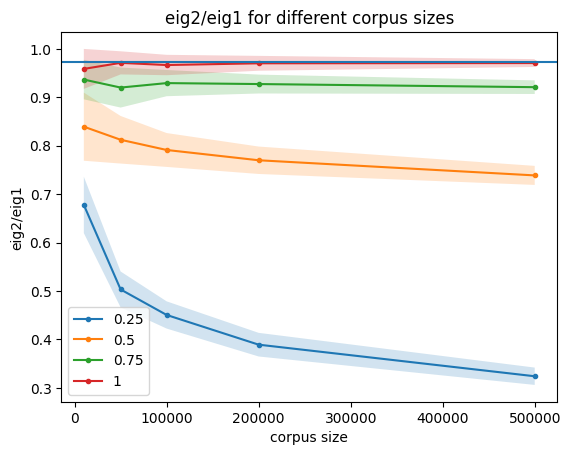

In [108]:
for alpha in alphas:
    means = np.mean(np.array([results[n][alpha] for n in num_samples])[:,:,1],axis=1)
    std = np.std(np.array([results[n][alpha] for n in num_samples])[:,:,1],axis=1)

    plt.plot(num_samples,means,marker=".",label=alpha)
    plt.fill_between(num_samples,means-std,means+std,alpha=0.2)

plt.axhline(y=(eigs_true/eigs_true[0])[1])

plt.title("eig2/eig1 for different corpus sizes")
plt.xlabel("corpus size")
plt.ylabel("eig2/eig1")

plt.legend()
plt.show()

In [81]:
std

array([0.07037629, 0.04912738, 0.03498376, 0.02831475, 0.01967646])

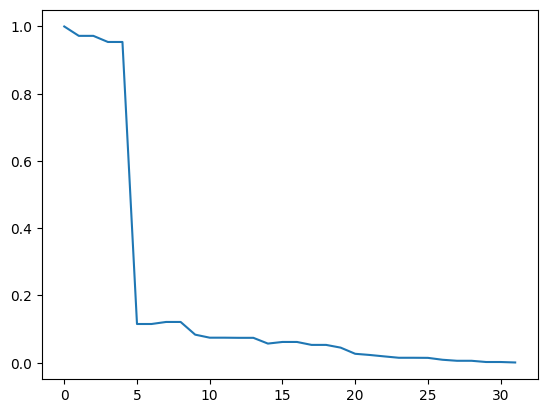

In [90]:
plt.plot(np.abs(eigs_true)/np.abs(eigs_true)[0])

In [65]:
np.mean(np.array(results[10000][0.5])[:,:5],axis=0)

array([1.        , 0.83939723, 0.83423447, 0.76962732, 0.76291627])

In [66]:
np.std(np.array(results[10000][0.5])[:,:5],axis=0)

array([0.        , 0.07037629, 0.07356119, 0.10080025, 0.10068083])

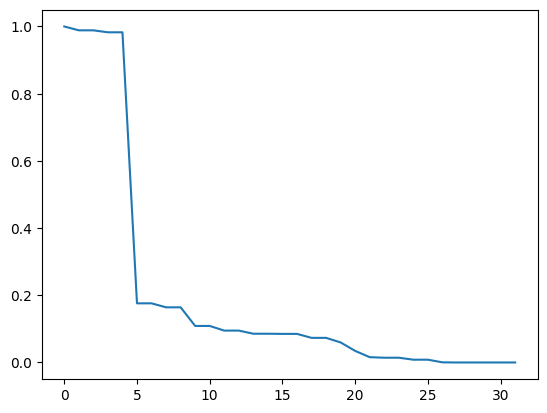

In [54]:
plt.plot(results[10000][1])

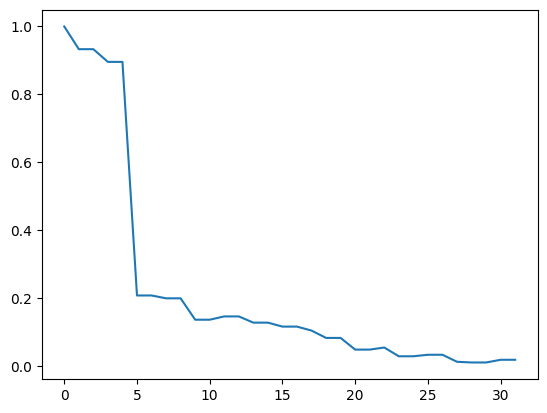

In [41]:
plt.plot(eigs)

In [21]:
(samples/samples.max())**0.75

array([[0.        , 0.        , 0.        , ..., 0.        , 0.0017439 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0017439 , 0.        , ..., 0.00668551, 0.        ,
        0.        ]])

In [25]:
eigs,evecs = np.linalg.eig(glove_importance_sampling(samples))

In [29]:
eigs = np.abs(eigs)

In [ ]:
s = np.random.zipf(a=1.2,size=10000)

In [ ]:
plt.plot(sorted(list(collections.Counter(s).values()))[::-1])
plt.xlim(0,10)

In [ ]:
plt.imshow(p_star)

In [ ]:
p_star.max()

In [ ]:
p_star.min()

In [ ]:
samples = sample_from_2d(p_star,10000,return_p_hat=False)

In [ ]:
samples

In [ ]:
max_val = np.max(samples)

In [ ]:
max_val

In [ ]:
(samples/max_val)**0.75

In [ ]:
count = np.bincount(s)
k = np.arange(1, s.max() + 1)
plt.bar(k, count[1:], alpha=0.5, label='sample count')


In [ ]:
p_star

In [109]:
num_samples = [10000,50000,100000,200000,500000]

results = {}

methods = ['mle',
            'gt',
            'svd',
            'interp',
            'add_k',
            'kneser_ney',
            'importance_sampling_glove',
            'eigenvalue_weighting',
            'cds_pmi',
            'dirichlet_pmi']

for n in num_samples:

    print(f"Number of samples {n}")

    results[n] = {}

    for method in methods:

        results[n][method] = {'eigs' : [], 'evecs' : [], 'mat' : []}

    for _ in range(50):

        samples = sample_from_2d(p_star,n,return_p_hat=False)

        # MLE estimate 
        mle = MLE_estimator(samples)
        eigs,evecs = np.linalg.eig(mle)
        results[n]['mle']['eigs'].append(eigs[:2])
        results[n]['mle']['evecs'].append(evecs[:,:2])
        results[n]['mle']['mat'].append(mle )

        # Good Turing Estimator
        gt = good_turing_estimator(samples)
        eigs,evecs = np.linalg.eig(gt)
        results[n]['gt']['eigs'].append(eigs[:2])
        results[n]['gt']['evecs'].append(evecs[:,:2])
        results[n]['gt']['mat'].append(gt )

        # SVD reconstruction
        svd = svd_smoothing(samples)
        eigs,evecs = np.linalg.eig(svd)
        results[n]['svd']['eigs'].append(eigs[:2])
        results[n]['svd']['evecs'].append(evecs[:,:2])
        results[n]['svd']['mat'].append(svd )

        # Interpolation with uniform prior
        interp = interpolation_smoothing(samples,0.95)
        eigs,evecs = np.linalg.eig(interp)
        results[n]['interp']['eigs'].append(eigs[:2])
        results[n]['interp']['evecs'].append(evecs[:,:2])
        results[n]['interp']['mat'].append(interp )

        # Add-k smoothing
        add_k = add_k_smoothing(samples,k=1)
        eigs,evecs = np.linalg.eig(add_k)
        results[n]['add_k']['eigs'].append(eigs[:2])
        results[n]['add_k']['evecs'].append(evecs[:,:2])
        results[n]['add_k']['mat'].append(add_k )

        # kneser ney smoothing
        kneser_ney = kneser_ney_smoothing(samples)
        eigs,evecs = np.linalg.eig(kneser_ney)
        results[n]['kneser_ney']['eigs'].append(eigs[:2])
        results[n]['kneser_ney']['evecs'].append(evecs[:,:2])
        results[n]['kneser_ney']['mat'].append(kneser_ney )

        # importance sampling (from GloVe)
        importance_sampling_glove = glove_importance_sampling(samples)
        eigs,evecs = np.linalg.eig(importance_sampling_glove)
        results[n]['importance_sampling_glove']['eigs'].append(eigs[:2])
        results[n]['importance_sampling_glove']['evecs'].append(evecs[:,:2])
        results[n]['importance_sampling_glove']['mat'].append(importance_sampling_glove )

        # eigenvalue weighting 
        eigenvalue_weighting_ = eigenvalue_weighting(samples,p=0.5)
        eigs,evecs = np.linalg.eig(eigenvalue_weighting_)
        results[n]['eigenvalue_weighting']['eigs'].append(eigs[:2])
        results[n]['eigenvalue_weighting']['evecs'].append(evecs[:,:2])
        results[n]['eigenvalue_weighting']['mat'].append(eigenvalue_weighting_)

        # Estimates for PMI Matrix

        # cds smoothing
        cds_pmi = cds_smoothing(samples)
        cds_ppmi = convert_to_ppmi(cds_pmi)
        eigs,evecs = np.linalg.eig(cds_ppmi)
        results[n]['cds_pmi']['eigs'].append(eigs[:2])
        results[n]['cds_pmi']['evecs'].append(evecs[:,:2])
        results[n]['cds_pmi']['mat'].append(cds_ppmi)

        # dirichlet smoothing
        dirichlet_pmi = dirichlet_smoothing(samples)
        dirichlet_ppmi = convert_to_ppmi(dirichlet_pmi)
        eigs,evecs = np.linalg.eig(dirichlet_ppmi)
        results[n]['dirichlet_pmi']['eigs'].append(eigs[:2])
        results[n]['dirichlet_pmi']['evecs'].append(evecs[:,:2])
        results[n]['dirichlet_pmi']['mat'].append(dirichlet_ppmi)
        

Number of samples 10000


/Users/utsavdutta/Desktop/Sem3/Research/representation_learning/smoothing.py:77: RuntimeWarning: invalid value encountered in divide
  l = (d * np.sum(np.sign(samples),axis=0,keepdims=True))/counts_context
/Users/utsavdutta/Desktop/Sem3/Research/representation_learning/smoothing.py:79: RuntimeWarning: invalid value encountered in divide
  p_word_given_context = (np.maximum(samples - d,0) / counts_context) + l * (counts_word / samples.sum())


LinAlgError: Array must not contain infs or NaNs

In [ ]:
import pandas as pd
df = pd.DataFrame(index=methods,columns=num_samples)

In [ ]:
for method in methods:
    for n in num_samples:

        if 'pmi' not in method:
            df.loc[method][n] = (np.mean(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]),\
                np.std(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]))
        # else:
        #     df.loc[method][n] = (np.mean(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]),\
        #         np.std(np.abs(np.array(results[n][method]['eigs']) -  eigs_true_pmi[:2])[:,0]),6)

In [ ]:
df

In [ ]:
import pandas as pd
df2 = pd.DataFrame(index=methods,columns=num_samples)

In [ ]:
for method in methods:
    for n in num_samples:

        if 'pmi' not in method:
            df2.loc[method][n] = (
                np.mean(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],axis=1)) , \
                    np.std(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],axis=1))
            )
            #  np.mean(np.abs(np.array(results[n][method]['evecs']) -  eigs_true_pmi[:2])[:,0])
        # else:
        #     df2.loc[method][n] = np.mean(np.abs(np.array(results[n][method]['evecs']) -  eigs_true[:2])[:,0])

In [ ]:
df2

In [ ]:
df3 = pd.DataFrame(index=methods,columns=num_samples)

In [ ]:
for method in methods:

    for n in num_samples:

        df3.loc[method][n] = (
            np.mean(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],np.inf,axis=1))
            ,
            np.round(np.std(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],np.inf,axis=1)),6)
        )

In [ ]:
df3

In [ ]:
for method in methods:

    if 'pmi' in method:
        data = [(n,np.abs(np.array(results[n][method]['eigs']) -  eigs_true_pmi[:2])[:,0]) for n in num_samples]
    else:
        data = [(n,np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]) for n in num_samples]

    y_values = [y for x,y in data]
    plt.boxplot(y_values, positions=[0,1,2],widths=0.2,meanline=True,showmeans=True)
    plt.plot([0,1,2],[np.mean(i) for i in y_values],label=method)


plt.xticks([0,1,2],[10000,50000,100000])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,2)
plt.show()

In [ ]:
plt.boxplot()

In [ ]:
plt.bar(x=0,height=np.abs(np.array(results[10000]['mle']['eigs']) -  eigs_true[:2])[:,0])

In [ ]:
np.abs(np.array(results[100000]['mle']['eigs']) -  eigs_true[:2])

In [ ]:
methods = list(results[10000].keys())

In [ ]:
methods

In [ ]:
for method in methods:

    for n in num_samples:
        
        eigs = results[n][method]['eigs']
        evecs = results[n][method]['eigs']

        if 'pmi' in method:

            eigs_error = np.abs(eigs - eigs_true_pmi[:2])
            evecs_error = evecs - evecs_true_pmi[:,:2]

        else:

            eigs_error = np.abs(eigs - eigs_true[:2])
            evecs_error = evecs - evecs_true[:,:2]

        print(n,method,eigs_error)


In [ ]:
evecs_error

In [ ]:
eigs_true